In [62]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import math, sys, os

## Binary outcomes

The Beta-Binomial model nicely models a series of success and failure trials.  The Binomial distribution represents the probability of X successes in a series of independent, success or failure trials.  The Binomial distribution has two parameters, n, the number of total trials, and p, the probabiliuty of success for any given trial.  A bayesian treatment of the Binomial requires that we specify a distribution for the parameter P.  The beta distribution is often used to model this parameter becaue it is a (conjucate prior)[https://en.wikipedia.org/wiki/Conjugate_prior] for the binomial success parameter.

We specify a model like so:

X ~ Bino(n, p), where p ~ Beta(a,b)

Where the binomail formula for P(K = k | n, p) = n_choose_k(k,n) * p^k * (1-p)^(n-k)
and the formula for the Beta distribution is P(X = x | a, b) = (x^(a-1) * (1-x) ^ (b-1)) / Beta(a,b),
where Beta(a,b) is the beta function.

The Bayesian update of the conjugate beta prior, given data, is specified like so:

P(p = p | n, k, a, b) = Beta(a + k, b + n - k), where Beta is, this time, the Beta distribution.


### Some methods

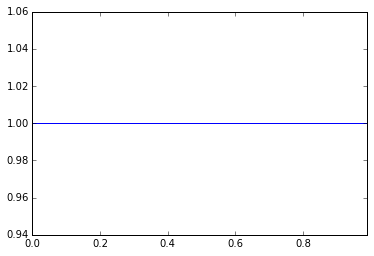

In [63]:
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import bernoulli
import pandas as pd

class BetaBinomial:
    
    def __init__(self, a, b):
        self.n = 0
        self.k = 0
        self.a = a
        self.b = b
        self.beta = beta(a,b)
    
    def __update_beta(self):
        self.beta = beta(self.a ,self.b)
    
    def update(self, k, n):
        self.a += k
        self.b += n - k
        self.__update_beta()
        self.n += n
        self.k += k
    
    def show_posterior_pdf(self, points = 100):
        """ pandas me for easy graphing """
        x = [x / float(points) for x in range(points)]
        pdf = [self.beta.pdf(i) for i in x]
        pdf = pd.Series(pdf, index=x)
        pdf.plot()
    

BB = BetaBinomial(1,1) # flat, uninformative, prior
BB.show_posterior_pdf()

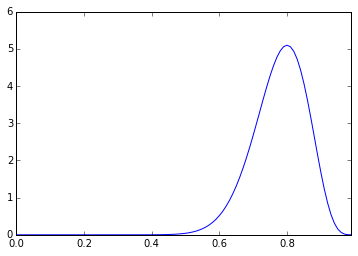

In [64]:
BB.update(20,25)
BB.show_posterior_pdf()

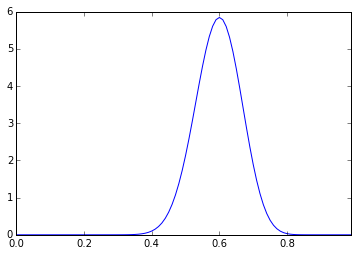

In [65]:
BB.update(10,25)
BB.show_posterior_pdf()

### Comparing two predictive models

Now, say we have two trained, predictive models, a and b, and we wish to test the probability if B will beat A in the long run.  Using BetaBinomial model for the success parameters, as we did above, we can compute the probability of b's long term success, over a, like so:

P(P_b > P_a) = Sum_0_to_S_b(  Beta(S_a + i, F_b + F_a) / ( (F_b + i) * Beta(1 + i, F_b) * Beta(S_a, F_a) ) ,

where:
    
    S_a: 1 + number of successes for a, 
    S_b: 1 + the successes for b, 
    F_a: 1 + the failures for a, 
    F_b: 1 + the failures for b, and
    Beta(a,b) is the beta function

To avoid overflowing float precision, we can perform the products as sums and subtractions of the logs.

f = LnBeta(S_a + i, F_b + F_a) - Ln(F_b + i) - LnBeta(1 + i, F_b) - LnBeta(S_a, F_a)

A nice treatment of the derivation can be found [here](http://www.evanmiller.org/bayesian-ab-testing.html).

In [66]:
from scipy.special import betaln

def formula(S_a, F_a, S_b, F_b):
    def iterative(i):        
        return np.exp( betaln(S_a + i, F_b + F_a) - 
                  np.log(F_b + i) - 
                  betaln(1 + i, F_b) - 
                  betaln(S_a, F_a) )
    return iterative
    

def prob_b_wins(S_a, F_a, S_b, F_b):
    iter_formula = formula(S_a + 1, F_a + 1, S_b + 1, F_b + 1)
    cum = 0.0
    for i in range(S_b):
        cum += iter_formula(i)
    return cum

print prob_b_wins(20, 3, 4, 5)
print prob_b_wins(2, 3, 4, 5)
print prob_b_wins(20, 3, 400, 5)

0.00467157240238
0.454545454545
0.999205973314


### Extending to three models


We can extend the test to compare the probability of success of a model, to two other models using the law of total probability:
    
P(P_c > max(P_a,P_b)) = 1 - P(P_a > P_c) - P(P_b > P_c) + intersection

    where intersection = 
        Sum_i_in_0_to_S_a, 
            Sum_j_in_0_to_S_b(  
                Beta(i + j + S_c, F_c + F_b + F_a) / 
                ( (F_a + i) * (F_b + j) * Beta(1 + i, F_a) * Beta(1 + j, F_b) * Beta(S_c, F_c) )
            )


In [67]:
from scipy.special import betaln

def formula_3way(S_a, F_a, S_b, F_b, S_c, F_c):
    def iterative(i, j):
        return np.exp( betaln(i + j + S_c, F_c + F_b + F_a) - 
                      np.log(F_a + i) - 
                      np.log(F_b + j) - 
                      betaln(1 + i, F_a) - 
                      betaln(1 + j, F_b) - 
                      betaln(S_c, F_c) )
    return iterative
    

def prob_c_wins(S_a, F_a, S_b, F_b, S_c, F_c):
    iter_formula = formula_3way(S_a + 1, F_a + 1, S_b + 1, F_b + 1, S_c + 1, F_c + 1)
    intersection = 0.0
    for i in range(S_a):
        for j in range(S_b):
            intersection += iter_formula(i, j)
    return 1 - prob_b_wins(S_c, F_c, S_a, F_a) - prob_b_wins(S_c, F_c, S_b, F_b) + intersection


print prob_c_wins(10,20,15,20,10,50)
print prob_c_wins(10,20,15,20,10,15)
print prob_c_wins(10,20,15,20,10,5)

0.0016089283832
0.421801227291
0.940138540633
